In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class SMABacktester(): 
    ''' Class for the vectorized backtesting of SMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA_S: int
        time window in days for shorter SMA
    SMA_L: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA parameters
        
    test_strategy:
        runs the backtest for the SMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates SMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SMA parameters
    '''
    
    def __init__(self, symbol, SMA_S, SMA_L, start, end, tc):
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA_S"] = raw["price"].rolling(self.SMA_S).mean()
        raw["SMA_L"] = raw["price"].rolling(self.SMA_L).mean()
        self.data = raw
        
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        # absolute performance of the strategy
        perf = data["cstrategy"].iloc[-1] 
        # out-/underperformance of strategy
        outperf = perf - data["creturns"].iloc[-1] 
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {} | TC = {}".format(self.symbol, self.SMA_S, self.SMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.

        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [3]:
tester = SMABacktester("EURUSD=X", 50, 200, "2004-01-01", "2020-06-30", 0.0007)

In [4]:
tester

SMABacktester(symbol = EURUSD=X, SMA_S = 50, SMA_L = 200, start = 2004-01-01, end = 2020-06-30)

In [5]:
tester.test_strategy()

(1.246315, 0.330489)

In [6]:
tester.results

,price,returns,SMA_S,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2004-10-07,1.229906,0.001475,1.221840,1.226081,-1,-0.001475,0.0,1.001476,0.998526
2004-10-08,1.241003,0.008982,1.222628,1.225995,-1,-0.008982,0.0,1.010511,0.989598
2004-10-11,1.238405,-0.002095,1.223352,1.225843,-1,0.002095,0.0,1.008396,0.991673
2004-10-12,1.232104,-0.005102,1.223888,1.225643,-1,0.005102,0.0,1.003265,0.996746
2004-10-13,1.234903,0.002270,1.224466,1.225497,-1,-0.002270,0.0,1.005545,0.994486
...,...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,1.101794,1.103430,-1,-0.002892,0.0,0.921130,1.236170
2020-06-25,1.125087,-0.005449,1.102486,1.103540,-1,0.005449,0.0,0.916125,1.242924
2020-06-26,1.122208,-0.002562,1.103213,1.103627,-1,0.002562,0.0,0.913781,1.246113


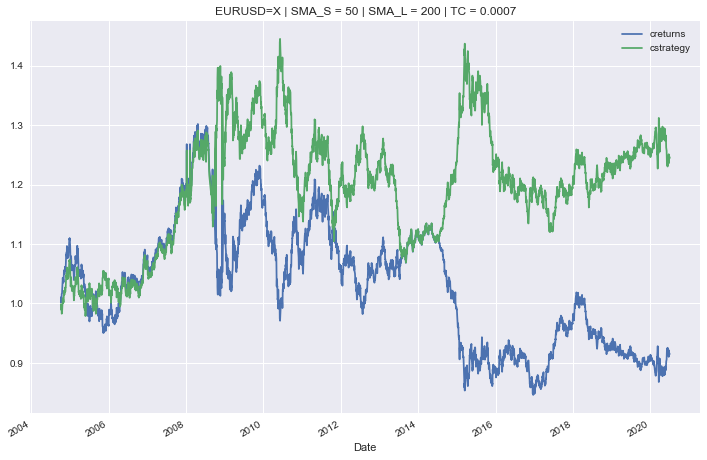

In [7]:
tester.plot_results()

In [8]:
tester.optimize_parameters((10, 50, 1), (51, 200, 1))

(array([ 46., 137.]), 2.432968)

In [9]:
tester.test_strategy()

(2.432968, 1.52732)

In [10]:
tester.results

,price,returns,SMA_S,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2004-07-12,1.240803,-0.000881,1.213333,1.227764,-1,0.000881,0.0,0.999119,1.000882
2004-07-13,1.233304,-0.006062,1.214392,1.227583,-1,0.006062,0.0,0.993081,1.006967
2004-07-14,1.238497,0.004202,1.215486,1.227362,-1,-0.004202,0.0,0.997263,1.002745
2004-07-15,1.235605,-0.002338,1.216466,1.227096,-1,0.002338,0.0,0.994934,1.005092
2004-07-16,1.245594,0.008051,1.217883,1.226961,-1,-0.008051,0.0,1.002977,0.997032
...,...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,1.103047,1.102654,1,-0.004292,2.0,0.910893,2.447059
2020-06-25,1.125087,-0.005449,1.103905,1.102737,1,-0.005449,0.0,0.905943,2.433762
2020-06-26,1.122208,-0.002562,1.104801,1.102788,1,-0.002562,0.0,0.903625,2.427534


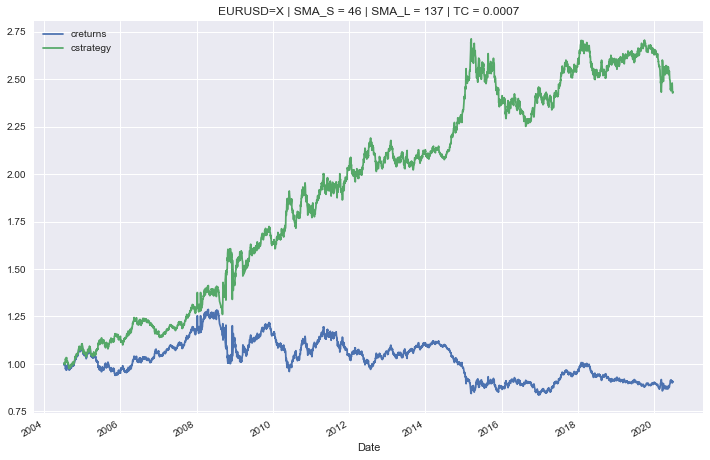

In [11]:
tester.plot_results()